In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.linear_model import Ridge

import math
import seaborn as sns

## Personal Part

### Description of the responsibility in the project

placeholder

## 1. Read the Data

In [2]:
df = pd.read_csv("/Users/yunzheyu/Desktop/Classes/BA476/Group Project/archive/spotify_songs.csv")

## 2. Heat Map

<AxesSubplot: >

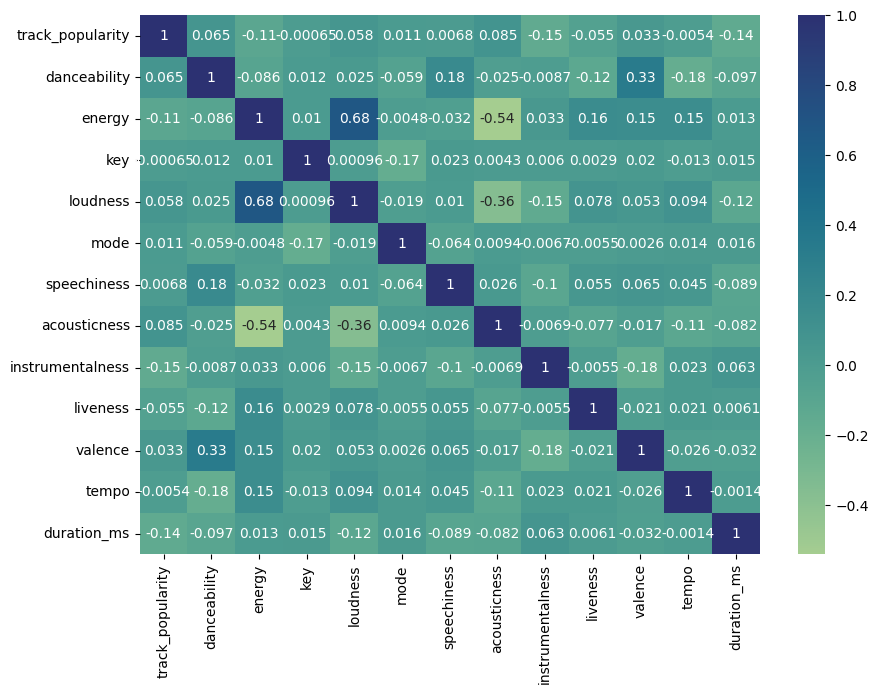

In [3]:
# heatmap by musics
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()
plt.figure(figsize=(10,7))
sns.heatmap(data=df[numerical_columns].corr(),annot=True,cmap='crest')

## 3. Clean the data

In [4]:
print(df.shape)
print(df.info())
print(df.describe())
df = df.drop_duplicates()
df = df.dropna()

clean_df = df.drop(['track_id','track_name','track_artist','track_album_id','track_album_name','track_album_release_date','playlist_name','playlist_id','playlist_subgenre'], axis=1)
clean_df.head()

one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(clean_df[['playlist_genre']])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(['playlist_genre']))
final_df= pd.concat([clean_df, one_hot_df], axis=1)
final_df.drop('playlist_genre', axis=1, inplace=True)
final_df = final_df.dropna()

(32833, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  

## 4. Train Test Split

In [5]:

X = final_df.drop(['track_popularity'],axis = 1)
y = final_df['track_popularity']
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Naive Rule

In [6]:
#mean of the target variable in the training set
naive_mean = np.mean(y_train)

#predictions using mean for both training and test sets
naive_train_pred = np.full_like(y_train, fill_value=naive_mean)
naive_pred = np.full_like(y_test, fill_value=naive_mean)

#RMSE
naive_train_rmse = mean_squared_error(y_train, naive_train_pred, squared=False)
naive_rmse = mean_squared_error(y_test, naive_pred, squared=False)

print("Naive Rule Train RMSE (Predicting Mean):", naive_train_rmse)
print("Naive Rule Test RMSE (Predicting Mean):", naive_rmse)


Naive Rule Train RMSE (Predicting Mean): 24.9554600659791
Naive Rule Test RMSE (Predicting Mean): 25.081601718441735


## 5. Regularized Regression Model

In [7]:
#Ridge Regression

# Initialize Ridge Regression model
ridge_reg = Ridge(alpha=1.0)  # alpha is the regularization strength

# Fit the model on the training data
ridge_reg.fit(X_train, y_train)

# Predict on the training and test sets
ridge_train_pred = ridge_reg.predict(X_train)
ridge_pred = ridge_reg.predict(X_test)

# Calculate the RMSE for the training and test sets
ridge_train_rmse = mean_squared_error(y_train, ridge_train_pred, squared=False)
ridge_rmse = mean_squared_error(y_test, ridge_pred, squared=False)

print("Ridge Regression Train RMSE:", ridge_train_rmse)
print("Ridge Regression Test RMSE:", ridge_rmse)

#Lasso Regression
# Initialize Lasso Regression model
lasso_reg = Lasso(alpha=0.1)  # alpha is the regularization strength

# Fit the model on the training data
lasso_reg.fit(X_train, y_train)

# Predict on the training and test sets
lasso_train_pred = lasso_reg.predict(X_train)
lasso_pred = lasso_reg.predict(X_test)

# Calculate the RMSE for the training and test sets
lasso_train_rmse = mean_squared_error(y_train, lasso_train_pred, squared=False)
lasso_rmse = mean_squared_error(y_test, lasso_pred, squared=False)

print("Lasso Regression Train RMSE:", lasso_train_rmse)
print("Lasso Regression Test RMSE:", lasso_rmse)

Ridge Regression Train RMSE: 23.795542914606497
Ridge Regression Test RMSE: 23.939481377534253
Lasso Regression Train RMSE: 23.800294952656838
Lasso Regression Test RMSE: 23.948271214013218


## Visualization

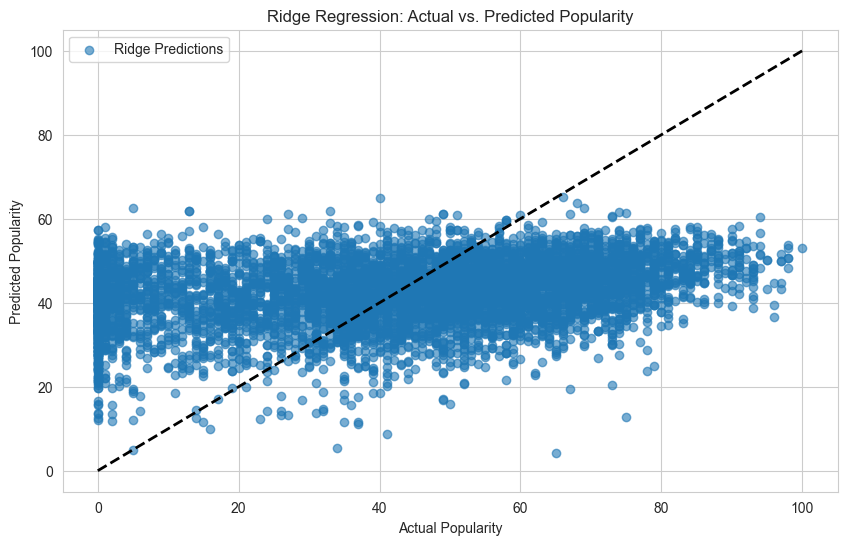

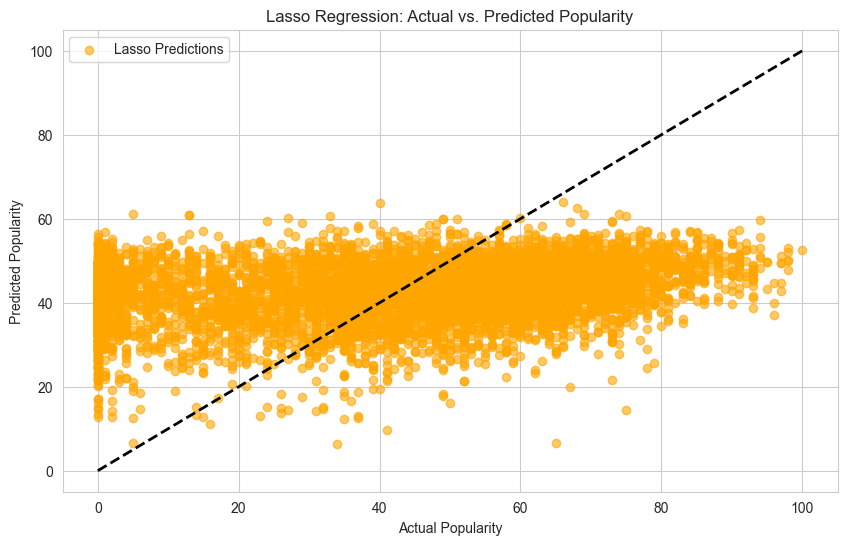

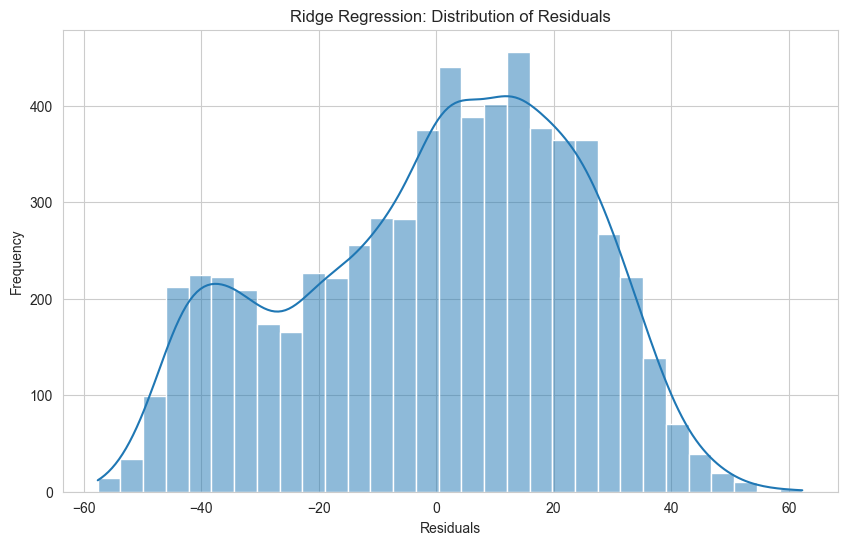

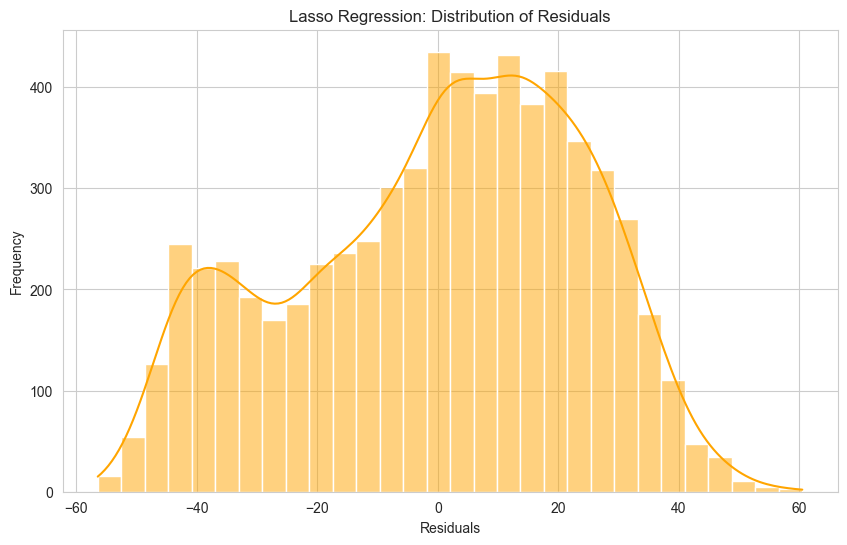

In [8]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Scatter plot for Ridge Regression Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ridge_pred, alpha=0.6, label='Ridge Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Diagonal line for perfect predictions
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Ridge Regression: Actual vs. Predicted Popularity')
plt.legend()
plt.show()

# Scatter plot for Lasso Regression Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lasso_pred, alpha=0.6, label='Lasso Predictions', color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Diagonal line for perfect predictions
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Lasso Regression: Actual vs. Predicted Popularity')
plt.legend()
plt.show()

# Histogram for Ridge Regression Residuals
ridge_residuals = y_test - ridge_pred
plt.figure(figsize=(10, 6))
sns.histplot(ridge_residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Ridge Regression: Distribution of Residuals')
plt.show()

# Histogram for Lasso Regression Residuals
lasso_residuals = y_test - lasso_pred
plt.figure(figsize=(10, 6))
sns.histplot(lasso_residuals, kde=True, color='orange')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Lasso Regression: Distribution of Residuals')
plt.show()

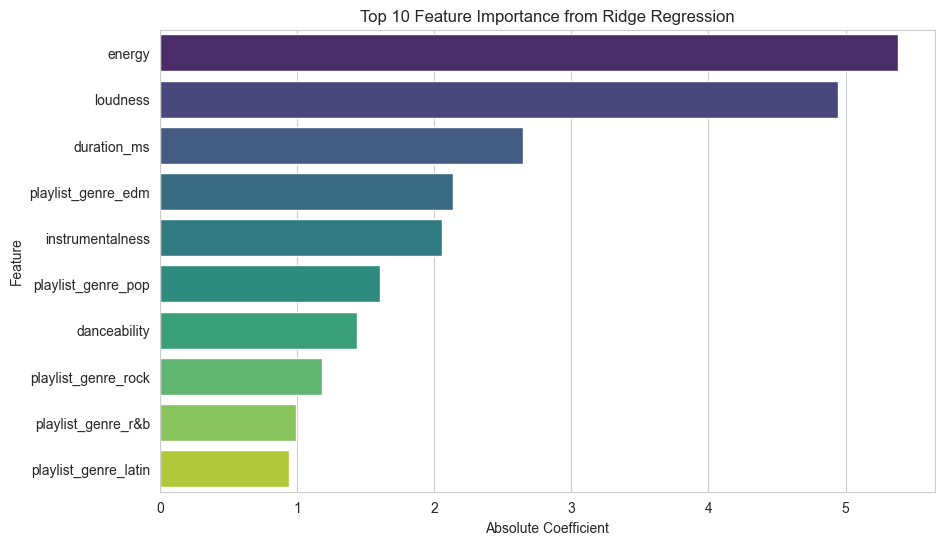

In [9]:
# Get the feature names after one-hot encoding (from previous code)
feature_names = list(X.columns)

# Get the coefficients from the Ridge regression model
ridge_coefficients = ridge_reg.coef_

# Create a DataFrame of features and their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_coefficients
})

# Calculate the absolute value of the coefficients for ranking
feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()

# Sort the features by the absolute value of their coefficient
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='abs_coefficient', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importance from Ridge Regression')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.show()
